In [ ]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt
import global_as
import global_as_gaussian_quad as global_as_gaussian_quad
from scipy.stats import norm
from scipy.stats import qmc

epsilon = 0.001
def dFunc(x):
    chi, dim = x.shape[0], x.shape[1]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

def dFunc0(x,Func,M2,shiftedSobol=True):
    chi,dim = x.shape[0],x.shape[1]
    temp = np.zeros((dim,chi*M2))

    if(shiftedSobol == True):
        rand_add = qmc.Sobol(dim, scramble=False).random(M2+1)[1:]    
        print(rand_add)    
        for i in range(M2):       
            xe = np.tile(x.transpose(), dim).transpose()*(1-np.repeat(np.array(np.identity(dim)), chi, axis=0))
            rand = (x+rand_add[i])%1
            xe += rand.T.reshape(dim*chi,1)*np.repeat(np.array(np.identity(dim)), chi, axis=0)
            temp[:,i*(chi):(i+1)*(chi)] = ((Func(xe)-np.tile(Func(x),dim))/np.sum(xe-np.tile(x.transpose(),dim).transpose(),axis=1)).reshape(dim,chi)
            
    else:
        for i in range(M2):       
            xe = np.tile(x.transpose(), dim).transpose()*(1-np.repeat(np.array(np.identity(dim)), chi, axis=0))
            rand = R.normal(0,1,(chi,dim))
            xe += rand.T.reshape(dim*chi,1)*np.repeat(np.array(np.identity(dim)), chi, axis=0)
            temp[:,i*(chi):(i+1)*(chi)] = ((Func(xe)-np.tile(Func(x),dim))/np.sum(xe-np.tile(x.transpose(),dim).transpose(),axis=1)).reshape(dim,chi)
    
    return temp

In [2]:
dim = 4
theta = [1]*dim #np.array(np.arange(1,dim+1,1))
A = R.normal(0,1,(dim,dim))

In [3]:
p = 1
chi = 200000
a = np.array(np.arange(1,dim+1,1))
k1 = 7
def Func(x):
    x = x - 0.5
    #return x@theta #+ 50*x[:,0]*x[:,1]
    #return x@theta + 0.5*np.sum((x@A)*x,axis = 1)
    return x@theta + 50*x[:,0] * (x[:,1])**5 #1(np.sin(20*x[:,1]*x[:,2]*x[:,-1]*x[:,-2])) + 0*R.normal(0,1,x.shape[0])

realprice = []
for i in range(10):
    z3 = R.uniform(0, 1, (1000000, dim))
    realprice.append(np.mean(Func(z3)))
realprice = sum(realprice)/len(realprice)
sigma2 = sum((Func(R.uniform(0, 1, (1000000, dim))) - realprice)**2)/1000000
sigma2

0.35122443150666854

In [ ]:
x, z, w = R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim))
upper, lower = [], []
for i in range(dim):
    fx, fz = Func(x), Func(z)
    x_uz, z_ux, w_ux = z.copy(), x.copy(), x.copy()
    x_uz[:,i], z_ux[:,i], w_ux[:,i] = x[:,i], z[:,i], w[:,i]
    upper.append(0.5*sum((fx - Func(z_ux))**2)/chi/sigma2)
    lower.append(sum((Func(x_uz) - fz)*(fx - Func(w_ux)))/chi/sigma2)
print(upper)
print(lower)

[0.28955643663956965, 0.2891046358206905, 0.2387261428475771, 0.2370920249481425]
[0.23671482640087554, 0.23748003280904062, 0.23948702757479629, 0.23616984229314636]


In [ ]:
epsilon = 10**-3
z = R.uniform(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.sqrt(chi)
uo, so, vho = np.linalg.svd(deriv.astype(float), full_matrices=False)  
so = so**2
DGSM = uo**2@so/sum(uo**2@so)
d1 = 2
as_score = uo[:,:d1]**2@so[:d1]/sum(uo[:,:d1]**2@so[:d1])

d1 = 1
M2 = 10
M1 = 20000
fd_result = global_as_gaussian_quad.calculate_finite_difference_matrix(
            f=Func,
            X=R.uniform(0, 1, (int(chi/2/M2), dim)),
            n_points=M2
        )
u, s, _ = np.linalg.svd(fd_result.T.astype(float), full_matrices=False)  
s = s**2
gas_score_full = u**2@s/sum(u**2@s)
gas_score = u[:,:d1]**2@s[:d1]/sum(u[:,:d1]**2@s[:d1])

In [56]:
def compute_C_u(x,Func,u,s,d1):
    expect = 0
    f = Func(x)
    for i in range(M2):
        for j in range(d1):
            dist = R.normal(0, 1)
            x_mod = x + (np.array([dist])*u[:,j:(j+1)]).transpose()
            f_mod = Func(x_mod)
            expect += np.sum(((f_mod - f)/dist)**2)
    return expect/M2/x.shape[0], np.sum(s[:d1]), expect/M2/x.shape[0] - np.sum(s[:d1])

M2 = 100
M1 = 100
z = R.normal(0, 1, (M1, dim))
print(compute_C_u(x,Func,u,s,1))

(11.530322196361714, 51.86251389737228, -40.332191701010565)


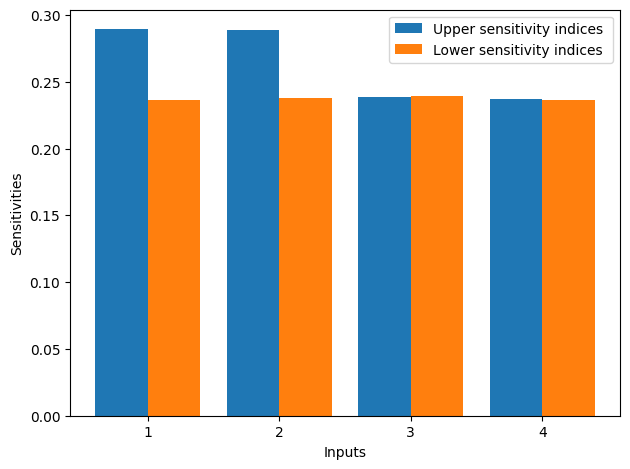

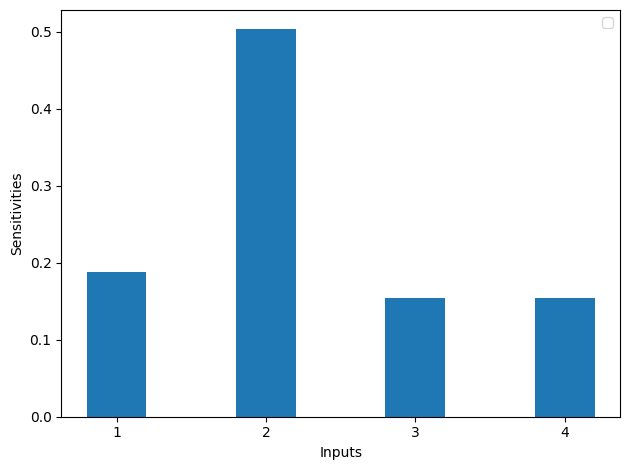

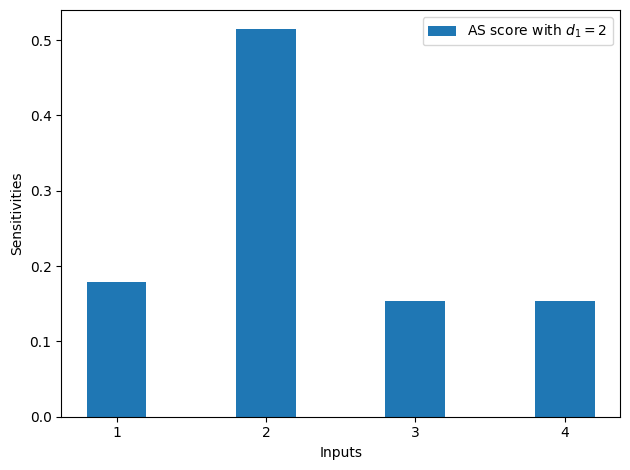

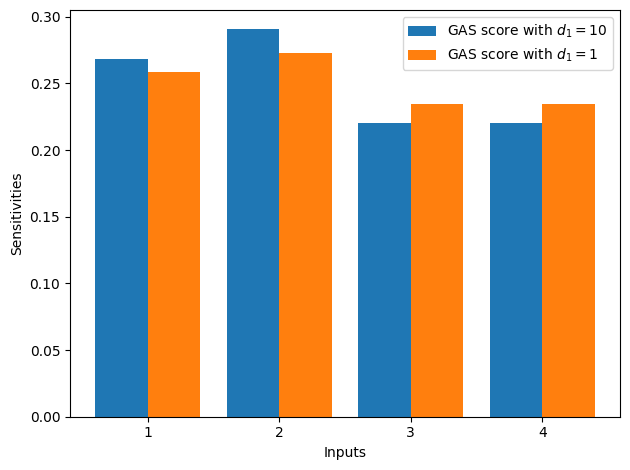

In [ ]:
width = 0.4
x = np.arange(1,dim+1)
labels = x
fig, ax = plt.subplots()

rects1 = ax.bar(x-width/2, upper, width, label='Upper sensitivity indices')
rects2 = ax.bar(x+width/2, lower, width, label='Lower sensitivity indices ')
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.savefig('gascore_paper/sobol4dim.png')

fig, ax = plt.subplots()
rects1 = ax.bar(x, DGSM, width)
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.savefig('gascore_paper/dgsm4dim.png')

fig, ax = plt.subplots()
rects1 = ax.bar(x, as_score, width, label='AS score with $d_1 = 2$')
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.savefig('gascore_paper/as4dim.png')

width = 0.4
x = np.arange(1,dim+1)
labels = x
fig, ax = plt.subplots()
rects1 = ax.bar(x-width/2, gas_score_full, width, label='GAS score with $d_1 = 10$')
rects2 = ax.bar(x+width/2, gas_score, width, label='GAS score with $d_1 = 1$')
ax.set_ylabel('Sensitivities')
ax.set_xlabel('Inputs')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.savefig('gascore_paper/gas4dim.png')